In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from preprocessing import preprocess_data, encode_label

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../data/Spotify_train_dataset.csv')

features_columns = ['danceability', 'energy', 'key', 'loudness', 'mode',
        'speechiness', 'acousticness', 'instrumentalness', 'liveness',
        'valence', 'tempo', 'duration_ms', 'time_signature']

label = 'genre'

In [3]:
from sklearn.preprocessing import LabelEncoder

df_normal = preprocess_data(df, features_columns, z_score=False, standardize=False)
print(f"Shape dataframe original :{df_normal.shape}")

le = LabelEncoder()
df_label_encoded = le.fit_transform(df[label])

df_normal_standardized = preprocess_data(df, features_columns, standardize=True)
print(f"Shape dataframe original standardized without outliers :{df_normal_standardized.shape}")


------------------------------------------
            Preprocessing data            
------------------------------------------
Get dataset
Shape of the data to process : (31728, 20)
------------------------------------------
Extract inputs ...
------------------------------------------
Data shape after preprocessing : (31728, 13)
Return dataset(s) ...
Preprocessing finished
------------------------------------------
Shape dataframe original :(31728, 13)
------------------------------------------
            Preprocessing data            
------------------------------------------
Get dataset
Shape of the data to process : (31728, 20)
------------------------------------------
Extract inputs ...
Center and reduce inputs ...
------------------------------------------
Data shape after preprocessing : (31728, 13)
Return dataset(s) ...
Preprocessing finished
------------------------------------------
Shape dataframe original standardized without outliers :(31728, 13)


In [4]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report

def compute_score(X, y, depth_list):
    scores = np.zeros(shape=len(depth_list))
    kfold = KFold(n_splits=10, random_state=5)

    for i, depth in enumerate(depth_list):

        tree = DecisionTreeClassifier(max_depth=depth, random_state=5)
        y_pred = cross_val_predict(tree, X, y, cv=kfold)

        recall = recall_score(y, y_pred, average='micro')
        precision = precision_score(y, y_pred, average='micro')

        f_score = 2 * (precision * recall) / (precision + recall)

        scores[i] = f_score

    return scores

def make_classification_report(X, y, class_names, clf):
    kfold = KFold(n_splits=10, random_state=5)
    y_pred = cross_val_predict(clf, X, y, cv=kfold)
    return classification_report(y, y_pred, target_names=class_names)

def plot_scores_vs_depth(depth_list, score_list, title):
    plt.plot(depth_list, score_list, label='F1-Score vs depth')
    plt.xlabel('Depth')
    plt.suptitle(title)
    plt.grid()
    plt.show()

In [5]:
y = df_label_encoded
clf = DecisionTreeClassifier(random_state=5)
X_train, X_test, y_train, y_test = train_test_split(df_normal, y, test_size=0.33, random_state=42)
clf.fit(X_train, y_train)
print(clf.get_depth())
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='micro')
precision = precision_score(y_test, y_pred, average='micro')
f_score = 2 * (precision * recall) / (precision + recall)
print(f'Accuracy :  {accuracy} | Score {f_score}')

30
Accuracy :  0.560118422309235 | Score 0.560118422309235


## Finding optimal depth

In [6]:
depth_list = [x for x in range(1, 35, 3)]

### 1) Normal dataset

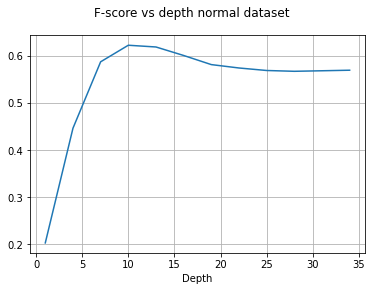

In [7]:
score_normal= compute_score(df_normal, y, depth_list)
plot_scores_vs_depth(depth_list, score_normal, 'F-score vs depth normal dataset')

### 2) Standardized dataset

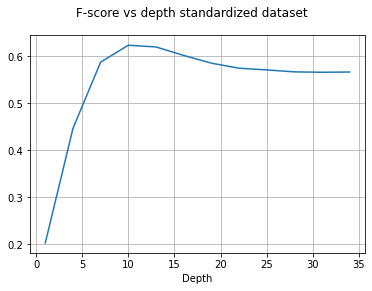

In [8]:
score_standardized= compute_score(df_normal_standardized, y, depth_list)
plot_scores_vs_depth(depth_list, score_standardized, 'F-score vs depth standardized dataset')

## Classification report for optimal depth

In [9]:

optimal_depth = depth_list[np.argmax(score_normal)]
clf = DecisionTreeClassifier(random_state=5, max_depth=optimal_depth)


print(make_classification_report(df_normal, df_label_encoded, le.classes_, clf))


                 precision    recall  f1-score   support

      Dark Trap       0.45      0.41      0.43      3378
            Emo       0.54      0.53      0.54      1262
         Hiphop       0.39      0.35      0.37      2255
            Pop       0.10      0.01      0.02       336
            Rap       0.90      0.27      0.42      1420
            RnB       0.30      0.34      0.32      1605
     Trap Metal       0.37      0.20      0.26      1474
Underground Rap       0.42      0.63      0.50      4378
            dnb       0.95      0.93      0.94      2213
      hardstyle       0.75      0.83      0.79      2178
      psytrance       0.89      0.88      0.88      2214
      techhouse       0.82      0.86      0.84      2254
         techno       0.83      0.80      0.81      2226
         trance       0.73      0.78      0.76      2275
           trap       0.76      0.71      0.74      2260

       accuracy                           0.62     31728
      macro avg       0.61   